## Generative Adversarial Network

In [10]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

device = 'cuda:0'
torch.cuda.set_device(0)

## Vanilla GAN

Vanilla GAN Loss:

$L(D, G) = - \frac1n \sum_{x_i \in X} \log D(x_i) - \frac1n \sum_{z_i \in N(0, 1)} \log (1 - D(G(z_i))) \rightarrow \min_{D} \max_{G}$

In practice, the discriminator and the generator are not trained simultaneously, but alternate $n$ optimization steps of the generator only and $m$ optimization steps of the discriminator only. At the same time, empirically it turns out better when the discriminator learns more steps than the generator.

$n$ and $m$ are hyperparameters and are selected for the task of the generator and discriminator architecture.



In [19]:
from typing import Optional
from typing_extensions import Literal

def gan_loss(real_objects_scores: torch.Tensor,
             generated_objects_scores: torch.Tensor, 
             by: Literal['generator', 'discriminator'] = 'generator') -> torch.Tensor:
  '''
  Computes losses for the generator and discriminator
  '''

  if by=='generator':
    # Returns generator loss
    return torch.log(1 - generated_objects_scores).mean()
  elif by == 'discriminator':
    # Returns discriminator loss
    return -torch.log(1 - generated_objects_scores).mean() - torch.log(real_objects_scores).mean()

def train_gan(tr_dataloader,
              gen, discr, 
              gen_opt, discr_opt,
              loss_func, prior,
              num_epochs, gen_steps, discr_steps,
              discr_params_clip_value=None,
              verbose_num_iters=100,
              data_type='2d'):

    gen.train()
    discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # Get real objects
            real_objects, y = batch
            real_objects = real_objects.to(device)
            y = y.to(device)
            
            # Generate new objects
            num_objects = real_objects.shape[0]
            z = prior.sample((num_objects, ))
            gen_objects = gen(z, y)

            # Compute scores
            real_objects_scores, gen_objects_scores = torch.split(discr(
                torch.cat([real_objects, gen_objects], dim=0), 
                torch.cat([y, y], dim=0)), num_objects)

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
              # Training step for generator
              gen_opt.zero_grad()
              gen_loss = loss_func(real_objects_scores, gen_objects_scores, 'generator')
              gen_loss.backward()
              gen_opt.step()
              gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
              # Training step for discriminator
              discr_opt.zero_grad()
              discr_loss = loss_func(real_objects_scores, gen_objects_scores, 'discriminator')
              discr_loss.backward()
              discr_opt.step()
              discr_loss_trace.append((iter_i, discr_loss.item()))
        
            iter_i += 1

            # Print losses and samples every verbose_num_iters
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 3, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Generator loss')
                plt.plot([p[0] for p in gen_loss_trace], 
                         [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Discriminator loss')
                plt.plot([p[0] for p in discr_loss_trace], 
                         [p[1] for p in discr_loss_trace], color='orange')
                    
                gen.eval()
                if data_type == '2d':
                  plt.subplot(1, 3, 3)
                  with torch.no_grad():
                    z = prior.sample((1024, ))
                    sampled_2d = gen(z)
                  plt.scatter(
                    sampled_2d[:, 0].cpu().detach().numpy(),
                    sampled_2d[:, 1].cpu().detach().numpy(),
                    s=1)
                elif data_type == 'mnist':
                  with torch.no_grad():
                    z = prior.sample((100, ))
                    sampled_mnist = gen(z, torch.arange(100).cuda() % 10)

                  for i in range(100):
                    plt.subplot(10, 30, 30 * (i // 10) + 21 + (i % 10))
                    plt.axis('off')
                    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

                plt.show()
                gen.train()
                
    gen.eval()
    discr.eval()

### 1.1 GAN on 2d data

In [20]:
from sklearn import datasets

s_x, s_y = datasets.make_s_curve(n_samples=10000, noise=0.01)
s_x = s_x[:, [0, 2]]

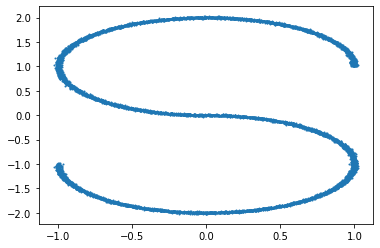

In [21]:
plt.scatter(s_x[:, 0], s_x[:, 1], s=1)

In [22]:
class Dataset2d:
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return self.x.shape[0]

In [23]:
class Generator2d(nn.Module):
  def __init__(self, lat_size):
    super(Generator2d, self).__init__()
    self.lat_size = lat_size

    self.net = nn.Sequential(
        nn.Linear(lat_size, 32), 
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Linear(32, 2))

  def forward(self, z: torch.Tensor, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    '''
    For batch of latent codes z returns the batch of generated objects
    '''
    return self.net(z)

class Discriminator2d(nn.Module):
  def __init__(self):
    super(Discriminator2d, self).__init__()

    self.net = nn.Sequential(
        nn.Linear(2, 32), 
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid())

  def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    '''
    For batch of objects returns scores
    '''
    return self.net(x)

 Let's train GAN

In [24]:
# create networks, optimizers, prior and dataloader

tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(s_x, dtype=torch.float32), 
              torch.tensor(s_y)),
              batch_size=64, shuffle=True, num_workers=1)

gen_2d = Generator2d(2)
gen_2d.cuda()

discr_2d = Discriminator2d()
discr_2d.cuda()

prior_2d = torch.distributions.Normal(torch.zeros(2).cuda(), torch.ones(2).cuda())

gen_opt_2d = optim.Adam(gen_2d.parameters(), lr=3e-4)
discr_opt_2d = optim.Adam(discr_2d.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [25]:
# train GAN

#try different combinations of generator/discriminator steps

train_gan(tr_dataloader_2d, gen_2d, discr_2d, gen_opt_2d, discr_opt_2d, gan_loss, prior_2d,
          num_epochs=30, gen_steps=1, discr_steps=3,
          verbose_num_iters=10)

KeyboardInterrupt: ignored

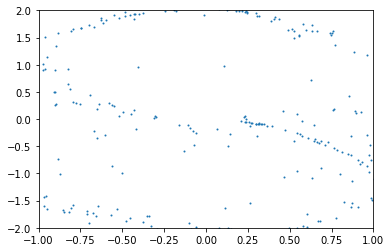

In [26]:
# visualize the resulting distribution

z = prior_2d.sample((256, ))

sampled_2d = gen_2d(z)

plt.xlim(-1, 1)
plt.ylim(-2, 2)

plt.scatter(sampled_2d[:, 0].cpu().detach().numpy(),
            sampled_2d[:, 1].cpu().detach().numpy(),
            s=1)

2D data is also great for demonstrating the weaknesses of GANs - when the data consists of several modes (clusters), GANs are subject to two scenarios:
1. **Mode collapse** - a situation when the GAN ignores some of the clusters and does not try to learn them.
2. **Mode mixing** - when a GAN connects two modes with an isthmus. This case, as a rule, is solved by taking a more powerful discriminator and generator.

In [27]:
circle_x, circle_y = datasets.make_circles(n_samples=10000, noise=0.01)

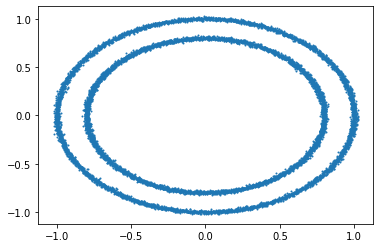

In [28]:
plt.scatter(circle_x[:, 0], circle_x[:, 1], s=1)

In [29]:
tr_dataloader_circle = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(circle_x, dtype=torch.float32), 
              torch.tensor(circle_y)),
              batch_size=64, shuffle=True, num_workers=1)

gen_circle = Generator2d(2)
gen_circle.cuda()

discr_circle = Discriminator2d()
discr_circle.cuda()

prior_circle = torch.distributions.Normal(torch.zeros(2).cuda(), torch.ones(2).cuda())

gen_opt_circle = optim.Adam(gen_circle.parameters(), lr=3e-4)
discr_opt_circle = optim.Adam(discr_circle.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [30]:
train_gan(tr_dataloader_circle, gen_circle, 
          discr_circle, gen_opt_circle, discr_opt_circle, 
          gan_loss, prior_circle,
          num_epochs=30, gen_steps=1, discr_steps=3,
          verbose_num_iters=10)

KeyboardInterrupt: ignored

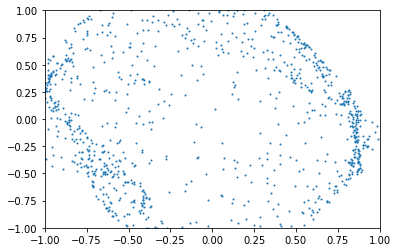

In [31]:
z = prior_circle.sample((1024, ))

sampled_circle = gen_circle(z)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.scatter(sampled_circle[:, 0].cpu().detach().numpy(),
            sampled_circle[:, 1].cpu().detach().numpy(),
            s=1)

Only one mode learned!

### 1.2 GAN on images

Now let's try to train GAN on more difficult data  -  MNIST dataset.

In [32]:
class GeneratorMNIST(nn.Module):
  def __init__(self, lat_size, hidden=64):
    super(GeneratorMNIST, self).__init__()
    self.lat_size = lat_size

    self.net = nn.Sequential(
        nn.Linear(lat_size, hidden),
        nn.BatchNorm1d(hidden),
        nn.ReLU(),
        nn.Linear(hidden, 2 * hidden),
        nn.BatchNorm1d(2 * hidden),
        nn.ReLU(),
        nn.Linear(2 * hidden, 4 * hidden),
        nn.BatchNorm1d(4 * hidden),
        nn.ReLU(),
        nn.Linear(4 * hidden, 32 * 32 ),
        nn.Tanh())

  def forward(self, z: torch.Tensor, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    '''
    For batch of latent codes z returns the batch of generated objects
    '''
    return self.net(z).view(-1, 1, 32, 32)

class DiscriminatorMNIST(nn.Module):
  def __init__(self, hidden=32):
    super(DiscriminatorMNIST, self).__init__()

    self.net = nn.Sequential(
        nn.Linear(32 *32, 4 * hidden), 
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(4 * hidden, 2 * hidden),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(2 * hidden, hidden),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(hidden, 1)) 

  def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    '''
    For batch of objects returns scores
    '''
    res = self.net(x.view(-1, 32 * 32))

    res = torch.sigmoid(res)

    return res

In [33]:
from torchvision.datasets import MNIST

transform = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [34]:
gen_mnist = GeneratorMNIST(100)
gen_mnist.cuda()

discr_mnist = DiscriminatorMNIST()
discr_mnist.cuda()

prior_mnist = torch.distributions.Normal(torch.zeros(100).cuda(), torch.ones(100).cuda())

gen_opt_mnist = optim.Adam(gen_mnist.parameters(), lr=3e-4)
discr_opt_mnist = optim.Adam(discr_mnist.parameters(), lr=3e-4, betas=(0.5, 0.999))

In [35]:
train_gan(trainloader_mnist, gen_mnist, 
          discr_mnist, gen_opt_mnist, discr_opt_mnist, 
          gan_loss, prior_mnist,
          num_epochs=20, gen_steps=1, discr_steps=1,
          verbose_num_iters=100, data_type='mnist')

KeyboardInterrupt: ignored

In [ ]:
z = prior_mnist.sample((16, ))

sampled_mnist = gen_mnist(z)

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

It takes quite a long time (more than 200 epochs) to fully train Vanilla GAN on MNIST, but after 20 epochs the generated images become similar to real objects, albeit a little noisy.